<h1 align="center"> Natural Language Processing </h1>

<a name="content"> </a>
## <font color="green"> Home assignment 3 </font> Text Classification

### Work had been done by: Ryabykin Aleksey
---

# Outline

* [Data Loading and Preprocessing](#step1)
* [Statistical Learning Approaches](#step2)
    * Multinomial Logistic Regression
    * Support Vector Machine
    * Random Forest
    * KNN (K-nearest Neighbors) 
    * SpaCy Approaches
* [Neural Networks Approach](#step3)
    * LSTM (Long Short-Term Memory)
    * GRU (Gated Recurrent Unit)
    * BiLSTM (Bidirectional LSTM)
* [Comparisons](#step4)

In [1]:
!python -m spacy download en_core_web_md
!pip install keras_preprocessing

2023-03-18 20:40:59.139399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 20:41:01.479948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-18 20:41:01.480084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-18 20:41:01.480111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

<a name="step1"></a>
# Data Loading and Preprocessing

[To the ToC](#content)

In [2]:
! wget https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_intents.csv
! wget https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_utterances.txt


--2023-03-18 20:41:32--  https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_intents.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391936 (383K) [text/plain]
Saving to: ‘atis_intents.csv’

atis_intents.csv    100%[===================>] 382.75K  --.-KB/s    in 0.04s   

2023-03-18 20:41:32 (10.4 MB/s) - ‘atis_intents.csv’ saved [391936/391936]

--2023-03-18 20:41:32--  https://raw.githubusercontent.com/PacktPublishing/Mastering-spaCy/main/Chapter06/data/atis_utterances.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, aw

In [3]:
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline, make_pipeline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm 
import random
import matplotlib.pyplot as plt
import seaborn as sns
SEED = 0xDEAD
random.seed(SEED)

In [4]:
nlp = spacy.load("en_core_web_md")

In [5]:
DATA_PATH = "./atis_intents.csv"

In [6]:
data = pd.read_csv(DATA_PATH, names=["intent", "utterance"])
data.sample(10)

,intent,utterance
1156,atis_flight,earliest flight from atlanta to philadelphia
4700,atis_flight,what's the latest flight out of denver that a...
2176,atis_capacity,how many people fit on a 73s
3178,atis_flight,find the earliest flight from boston to san f...
3545,atis_flight,okay on monday may thirty first i'd like to g...
3540,atis_flight,what flights are available friday afternoon f...
1527,atis_flight,show me flights from dallas to san francisco ...
2371,atis_airline,what airlines fly between san francisco and d...
4165,atis_flight,what flights from phoenix to las vegas on sat...
98,atis_flight,where does canadian airlines international fly


In [7]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word in stop_words]    
    text = ' '.join(tokens)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
data.utterance = data.utterance.apply(preprocess_text)
le = LabelEncoder()
data.intent = le.fit_transform(data.intent)

In [9]:
n_classes = len(le.classes_)

In [10]:
train_data, test_data = train_test_split(data, test_size=0.2)

train_texts = train_data.utterance.values
train_labels = train_data.intent.values

test_texts = test_data.utterance.values
test_labels = test_data.intent.values

In [11]:
train_data.describe()

,intent
count,3982.000000
mean,10.831994
std,3.977663
min,0.000000
25%,12.000000
50%,12.000000
75%,12.000000
max,21.000000


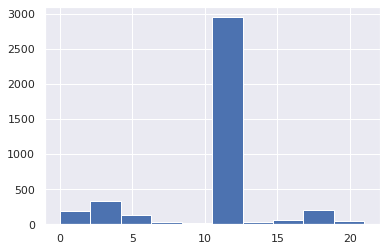

In [12]:
sns.set()
plt.hist(train_labels);

Data is very bad balanced. It may cause some bad influence on results.

Let's take vectors by SpaCy functionality as features for utterances.

In [13]:
import numpy as np
def get_features(docs):
    features = []
    for doc in nlp.pipe(docs, disable=["parser", "tagger", "ner", "pos"]):
        if doc.has_vector:
            features.append(doc.vector)
        else:
            features.append(np.zeros((nlp.vocab.vectors_length,)))
    return np.array(features)

In [84]:
train_features = get_features(train_texts)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2)

X_test = get_features(test_texts)
y_test = test_labels

<a name="step2"> </a>

# Statistical Learning Approaches

[To the ToC](#content)

In [15]:
from typing import Iterable
def print_result(y_true: Iterable, y_pred: Iterable):
    return pd.DataFrame(classification_report(y_pred=le.inverse_transform(y_pred), y_true=le.inverse_transform(y_true), output_dict=True)).T.round(2)

scores = {"validation": {},
          "test": {}}

## Multinomial Logistic Regression

In [19]:
lr = LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-3)
parameters = {'C': np.linspace(10, 120, 10)}
grid_lr = GridSearchCV(lr, param_grid=parameters, verbose=2)

grid_lr.fit(X_train, y_train)

print(f'The best hyperparameter C is {grid_lr.best_params_["C"]}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .............................................C=10.0; total time=   9.2s
[CV] END .............................................C=10.0; total time=   8.7s
[CV] END .............................................C=10.0; total time=   7.9s
[CV] END .............................................C=10.0; total time=   8.4s
[CV] END .............................................C=10.0; total time=   8.8s
[CV] END ................................C=22.22222222222222; total time=   7.8s
[CV] END ................................C=22.22222222222222; total time=   8.7s
[CV] END ................................C=22.22222222222222; total time=   9.0s
[CV] END ................................C=22.22222222222222; total time=   7.6s
[CV] END ................................C=22.22222222222222; total time=   8.8s
[CV] END ................................C=34.44444444444444; total time=   8.8s
[CV] END ................................C=34.44

In [20]:
preds = grid_lr.predict(X_val)
print(f'f1_score = {f1_score(y_val, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val, preds)}')
scores["validation"]["LogisticRegression"] = {}
scores["validation"]["LogisticRegression"]["f1_score"] = f1_score(y_val, preds, average="macro")
scores["validation"]["LogisticRegression"]["accuracy_score"] = accuracy_score(y_val, preds)
print_result(preds, y_val)

f1_score = 0.9335006273525721
accuracy_score = 0.9335006273525721


,precision,recall,f1-score,support
atis_abbreviation,0.91,0.95,0.93,21.00
atis_aircraft,0.75,0.80,0.77,15.00
atis_airfare,0.96,0.83,0.89,58.00
atis_airline,0.72,0.91,0.81,23.00
atis_airport,0.67,0.67,0.67,3.00
atis_capacity,0.50,1.00,0.67,1.00
atis_city,0.50,0.67,0.57,3.00
atis_distance,0.33,0.50,0.40,2.00
atis_flight,0.98,0.96,0.97,617.00
atis_flight#atis_airfare,0.33,0.50,0.40,4.00


In [21]:
preds = grid_lr.predict(X_test)
print(f'f1_score = {f1_score(y_test, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test, preds)}')
scores["test"]["LogisticRegression"] = {}
scores["test"]["LogisticRegression"]["f1_score"] = f1_score(y_test, preds, average="macro")
scores["test"]["LogisticRegression"]["accuracy_score"] = accuracy_score(y_test, preds)
print_result(preds, y_test)

f1_score = 0.9327309236947792
accuracy_score = 0.9327309236947792


,precision,recall,f1-score,support
atis_abbreviation,0.89,0.93,0.91,27.00
atis_aircraft,0.93,0.68,0.79,19.00
atis_aircraft#atis_flight#atis_flight_no,0.00,0.00,0.00,0.00
atis_airfare,0.88,0.90,0.89,87.00
atis_airline,0.68,0.76,0.72,25.00
atis_airport,0.67,1.00,0.80,2.00
atis_capacity,0.00,0.00,0.00,0.00
atis_cheapest,0.00,0.00,0.00,0.00
atis_city,0.40,1.00,0.57,2.00
atis_distance,1.00,1.00,1.00,2.00


## Support Vector Machine (SVM)

In [22]:
parameters = {'C': [0.1, 1, 10, 100], 
              'gamma': [0.1, 0.01, 1],
              'kernel': ['linear', 'rbf']} 

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid=parameters, verbose=2)

grid_svm.fit(X_train, y_train)
print(f'The best hyperparameters are {grid_svm.best_params_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.6s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   7.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   7.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=0.01, 

In [23]:
preds = grid_svm.predict(X_val)
print(f'f1_score = {f1_score(y_val, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val, preds)}')
scores["validation"]["SVM"] = {}
scores["validation"]["SVM"]["f1_score"] = f1_score(y_val, preds, average="macro")
scores["validation"]["SVM"]["accuracy_score"] = accuracy_score(y_val, preds)
print_result(preds, y_val)

f1_score = 0.9410288582183187
accuracy_score = 0.9410288582183187


,precision,recall,f1-score,support
atis_abbreviation,0.95,0.95,0.95,22.00
atis_aircraft,0.88,0.78,0.82,18.00
atis_airfare,0.92,0.85,0.88,54.00
atis_airline,0.83,0.89,0.86,27.00
atis_airport,0.67,1.00,0.80,2.00
atis_capacity,0.50,1.00,0.67,1.00
atis_city,0.75,0.75,0.75,4.00
atis_distance,0.67,1.00,0.80,2.00
atis_flight,0.97,0.96,0.97,606.00
atis_flight#atis_airfare,0.83,0.62,0.71,8.00


In [24]:
preds = grid_svm.predict(X_test)
print(f'f1_score = {f1_score(y_test, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test, preds)}')
scores["test"]["SVM"] = {}
scores["test"]["SVM"]["f1_score"] = f1_score(y_test, preds, average="macro")
scores["test"]["SVM"]["accuracy_score"] = accuracy_score(y_test, preds)
print_result(preds, y_test)

f1_score = 0.9427710843373494
accuracy_score = 0.9427710843373494


,precision,recall,f1-score,support
atis_abbreviation,0.89,0.96,0.93,26.00
atis_aircraft,1.00,0.70,0.82,20.00
atis_aircraft#atis_flight#atis_flight_no,0.00,0.00,0.00,0.00
atis_airfare,0.87,0.89,0.88,87.00
atis_airfare#atis_flight_time,0.00,0.00,0.00,1.00
atis_airline,0.93,0.87,0.90,30.00
atis_airline#atis_flight_no,0.00,0.00,0.00,1.00
atis_airport,1.00,1.00,1.00,3.00
atis_capacity,0.00,0.00,0.00,0.00
atis_cheapest,0.00,0.00,0.00,0.00


## Random Forest

In [25]:
rf = RandomForestClassifier()
parameters = {'max_depth': [3, 5, 10, 20, 50],
               'min_samples_split': [2, 5, 10]}
grid_rf = GridSearchCV(rf, param_grid=parameters, verbose=2)

grid_rf.fit(X_train, y_train)
print(f'The best hyperparameters are {grid_rf.best_params_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.6s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.6s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.2s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.3s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.3s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.3s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.3s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.3s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   1.5s
[CV] END ..................max_depth=3, min_samp

In [26]:
preds = grid_rf.predict(X_val)
print(f'f1_score = {f1_score(y_val, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val, preds)}')
scores["validation"]["Random Forest"] = {}
scores["validation"]["Random Forest"]["f1_score"] = f1_score(y_val, preds, average="macro")
scores["validation"]["Random Forest"]["accuracy_score"] = accuracy_score(y_val, preds)
print_result(preds, y_val)

f1_score = 0.8870765370138017
accuracy_score = 0.8870765370138017


,precision,recall,f1-score,support
atis_abbreviation,0.91,0.91,0.91,22.00
atis_aircraft,0.38,0.86,0.52,7.00
atis_airfare,0.74,0.88,0.80,42.00
atis_airline,0.28,1.00,0.43,8.00
atis_airport,0.67,1.00,0.80,2.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.50,1.00,0.67,2.00
atis_distance,0.00,0.00,0.00,0.00
atis_flight,0.99,0.88,0.93,676.00
atis_flight#atis_airfare,0.50,0.60,0.55,5.00


In [27]:
preds = grid_rf.predict(X_test)
print(f'f1_score = {f1_score(y_test, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test, preds)}')
scores["test"]["Random Forest"] = {}
scores["test"]["Random Forest"]["f1_score"] = f1_score(y_test, preds, average="macro")
scores["test"]["Random Forest"]["accuracy_score"] = accuracy_score(y_test, preds)
print_result(preds, y_test)

f1_score = 0.8905622489959839
accuracy_score = 0.8905622489959839


,precision,recall,f1-score,support
atis_abbreviation,0.79,1.00,0.88,22.00
atis_aircraft,0.64,0.90,0.75,10.00
atis_aircraft#atis_flight#atis_flight_no,0.00,0.00,0.00,0.00
atis_airfare,0.60,0.91,0.72,58.00
atis_airline,0.43,0.86,0.57,14.00
atis_airport,0.67,1.00,0.80,2.00
atis_capacity,0.00,0.00,0.00,0.00
atis_cheapest,0.00,0.00,0.00,0.00
atis_city,0.20,1.00,0.33,1.00
atis_distance,0.50,1.00,0.67,1.00


## K-nearest Neighbors

In [28]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [3, 4, 5, 8, 10]}
grid_knn = GridSearchCV(knn, param_grid=parameters, verbose=2)

grid_knn.fit(X_train, y_train)
print(f'The best hyperparameters are {grid_knn.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ......................................n_neighbors=3; total time=   0.2s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=4; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_

In [29]:
preds = grid_knn.predict(X_val)
print(f'f1_score = {f1_score(y_val, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val, preds)}')
scores["validation"]["KNN"] = {}
scores["validation"]["KNN"]["f1_score"] = f1_score(y_val, preds, average="macro")
scores["validation"]["KNN"]["accuracy_score"] = accuracy_score(y_val, preds)
print_result(preds, y_val)

f1_score = 0.877038895859473
accuracy_score = 0.877038895859473


,precision,recall,f1-score,support
atis_abbreviation,0.95,0.84,0.89,25.00
atis_aircraft,0.44,0.54,0.48,13.00
atis_airfare,0.86,0.69,0.77,62.00
atis_airline,0.38,0.79,0.51,14.00
atis_airport,0.33,1.00,0.50,1.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.50,1.00,0.67,2.00
atis_distance,0.67,1.00,0.80,2.00
atis_flight,0.96,0.91,0.93,638.00
atis_flight#atis_airfare,0.67,0.67,0.67,6.00


In [85]:
preds = grid_knn.predict(X_test)
print(f'f1_score = {f1_score(y_test, preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test, preds)}')
scores["test"]["KNN"] = {}
scores["test"]["KNN"]["f1_score"] = f1_score(y_test, preds, average="micro")
scores["test"]["KNN"]["accuracy_score"] = accuracy_score(y_test, preds)
print_result(preds, y_test)

f1_score = 0.8965863453815262
accuracy_score = 0.8965863453815262


,precision,recall,f1-score,support
atis_abbreviation,0.89,1.00,0.94,25.0
atis_aircraft,0.79,0.69,0.73,16.0
atis_aircraft#atis_flight#atis_flight_no,0.00,0.00,0.00,0.0
atis_airfare,0.67,0.79,0.73,76.0
atis_airline,0.57,0.84,0.68,19.0
atis_airport,0.33,1.00,0.50,1.0
atis_capacity,0.00,0.00,0.00,0.0
atis_cheapest,0.00,0.00,0.00,0.0
atis_city,0.60,1.00,0.75,3.0
atis_distance,1.00,1.00,1.00,2.0


## SpaCy Approaches

In [31]:
from spacy.training import Example
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL

config = {
   "threshold": 0.5,
   "model": DEFAULT_MULTI_TEXTCAT_MODEL,
}

train_labels_spacy = le.inverse_transform(train_labels)
test_labels_spacy = le.inverse_transform(test_labels)

textcat = nlp.add_pipe('textcat_multilabel', config=config)

In [32]:
train_data = [(sentence, {"cats": {label_: int(label == label_) for label_ in le.classes_}}) for sentence, label in zip(train_texts, train_labels_spacy)]
train_examples = [Example.from_dict(nlp.make_doc(sentence), annotations) for sentence, annotations in train_data]
textcat.initialize(lambda: train_examples, nlp=nlp)
epochs = 20
with nlp.select_pipes(enable='textcat'):
    optimizer = nlp.resume_training()
    
    for _ in tqdm(range(epochs)):
        random.shuffle(train_data)

        for sentence, annotations in train_data:
            doc = nlp.make_doc(sentence)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd=optimizer)

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


In [33]:
import operator
preds_spacy = []
for text in test_texts:
    doc = nlp(text)
    stats = doc.cats
    preds_spacy.append(max(stats.items(), key=operator.itemgetter(1))[0])

In [81]:
scores["test"]["SpaCy"] = {}
scores["test"]["SpaCy"]["f1_score"] = f1_score(test_labels_spacy, preds_spacy, average="micro")
scores["test"]["SpaCy"]["accuracy_score"] = accuracy_score(test_labels_spacy, preds_spacy)

<a name="step3"> </a>
# Neural Networks Approaches

[To the ToC](#content)

In [39]:
# ! pip install keras_preprocessing

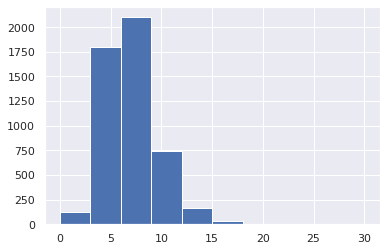

In [40]:
plt.hist(data.utterance.apply(lambda row: len(row.split())));

In [38]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GRU
from keras.metrics import Precision, Recall
from keras.optimizers import SGD, Adam
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

max_words = 5000
max_len = 15

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['utterance'][0])
X, tokenizer = tokenize_pad_sequences(data['utterance'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 want fly boston 838 arrive denver 1110 morning
After Tokenization & Padding 
 [ 44  21   3 337  53   6 457  20   0   0   0   0   0   0   0]


In [41]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [42]:
y = pd.get_dummies(data['intent'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2986, 15) (2986, 22)
Validation Set -> (996, 15) (996, 22)
Test Set -> (996, 15) (996, 22)


In [43]:
labels = list(y.columns)

In [44]:
vocab_size = 5000
embedding_size = 32
epochs=20

## LSTM (Long Short-Term Memory)

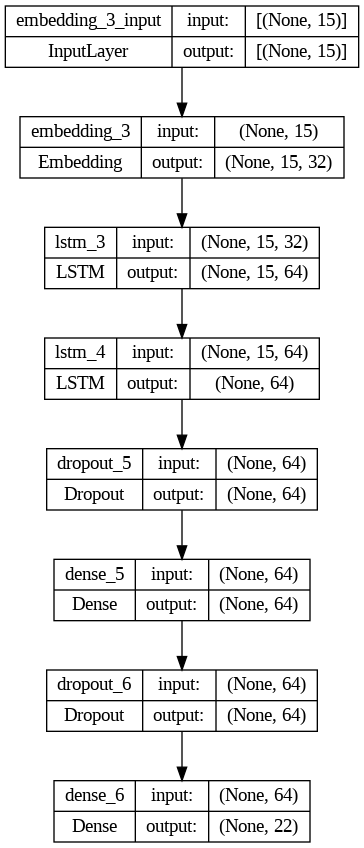

In [64]:
model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])
tf.keras.utils.plot_model(model, show_shapes=True)

In [65]:
learning_rate = 0.01

adam = Adam(learning_rate=learning_rate)

In [66]:
model.compile(loss='categorical_crossentropy', optimizer=adam, 
               metrics=['accuracy', Precision(), Recall()])

batch_size = 32
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
94/94 [==============================] - 6s 25ms/step - loss: 1.3107 - accuracy: 0.7220 - precision_3: 0.7833 - recall_3: 0.6015 - val_loss: 0.8773 - val_accuracy: 0.7580 - val_precision_3: 0.9326 - val_recall_3: 0.6807
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.9605 - accuracy: 0.7602 - precision_3: 0.9041 - recall_3: 0.6949 - val_loss: 0.8004 - val_accuracy: 0.8072 - val_precision_3: 0.9278 - val_recall_3: 0.7349
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 0.8504 - accuracy: 0.7890 - precision_3: 0.9250 - recall_3: 0.7187 - val_loss: 0.7147 - val_accuracy: 0.8133 - val_precision_3: 0.9259 - val_recall_3: 0.7400
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 0.7131 - accuracy: 0.8001 - precision_3: 0.9239 - recall_3: 0.7445 - val_loss: 0.6970 - val_accuracy: 0.7932 - val_precision_3: 0.9337 - val_recall_3: 0.7490
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.581

In [67]:
def predict_class(X_test, model):
    '''
    Function to predict classes
    '''
    
    results = []
    preds = model.predict(X_test).argmax(axis=1)
    for pred in preds:
        results.append(labels[preds[0]])
    return results

res = predict_class(X_train, model)

94/94 [==============================] - 1s 3ms/step


In [68]:
preds = model.predict(X_val).argmax(axis=1)
print(f'f1_score = {f1_score(y_val.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val.idxmax(axis=1), preds)}')
scores["validation"]["LSTM"] = {}
scores["validation"]["LSTM"]["f1_score"] = f1_score(y_val.idxmax(axis=1), preds, average="micro")
scores["validation"]["LSTM"]["accuracy_score"] = accuracy_score(y_val.idxmax(axis=1), preds)
print_result(preds, y_val.idxmax(axis=1))

32/32 [==============================] - 0s 3ms/step
f1_score = 0.9417670682730923
accuracy_score = 0.9417670682730924


,precision,recall,f1-score,support
atis_abbreviation,0.80,0.95,0.87,21.00
atis_aircraft,0.95,0.72,0.82,25.00
atis_airfare,0.96,0.87,0.91,85.00
atis_airline,0.95,0.83,0.89,48.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,0.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.00,0.00,0.00,0.00
atis_distance,0.00,0.00,0.00,1.00
atis_flight,0.98,0.99,0.99,737.00


In [69]:
preds = model.predict(X_test).argmax(axis=1)
print(f'f1_score = {f1_score(y_test.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test.idxmax(axis=1), preds)}')
scores["test"]["LSTM"] = {}
scores["test"]["LSTM"]["f1_score"] = f1_score(y_test.idxmax(axis=1), preds, average="micro")
scores["test"]["LSTM"]["accuracy_score"] = accuracy_score(y_test.idxmax(axis=1), preds)
print_result(preds, y_test.idxmax(axis=1))

32/32 [==============================] - 0s 3ms/step
f1_score = 0.9477911646586346
accuracy_score = 0.9477911646586346


,precision,recall,f1-score,support
atis_abbreviation,1.00,0.89,0.94,36.00
atis_aircraft,0.75,0.82,0.78,11.00
atis_airfare,0.95,0.91,0.93,88.00
atis_airline,0.95,0.95,0.95,40.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,1.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.00,0.00,0.00,0.00
atis_distance,0.00,0.00,0.00,2.00
atis_flight,0.99,0.99,0.99,729.00


## GRU (Gated Recurrent Unit)

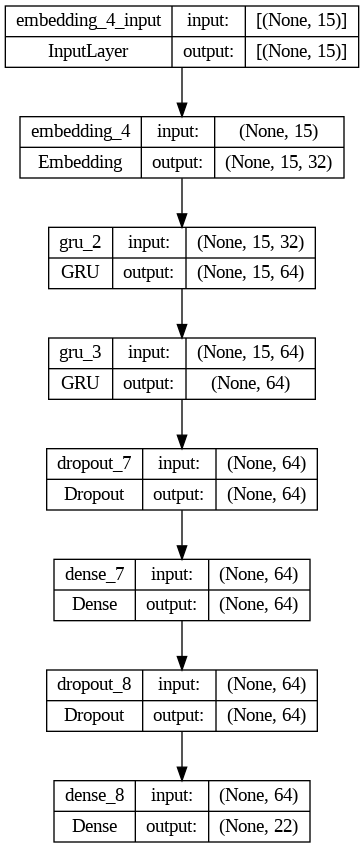

In [70]:
model = Sequential([
    Embedding(vocab_size, embedding_size, input_length=max_len),
    GRU(64, return_sequences=True),
    GRU(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])
tf.keras.utils.plot_model(model, show_shapes=True)

In [71]:
learning_rate = 0.01

adam = Adam(learning_rate=learning_rate)

In [72]:
model.compile(loss='categorical_crossentropy', optimizer=adam, 
               metrics=['accuracy', Precision(), Recall()])

batch_size = 32
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
94/94 [==============================] - 5s 18ms/step - loss: 1.1782 - accuracy: 0.7381 - precision_4: 0.8217 - recall_4: 0.6189 - val_loss: 0.6595 - val_accuracy: 0.8263 - val_precision_4: 0.9580 - val_recall_4: 0.7550
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.5710 - accuracy: 0.8476 - precision_4: 0.9578 - recall_4: 0.7987 - val_loss: 0.5200 - val_accuracy: 0.8695 - val_precision_4: 0.9672 - val_recall_4: 0.8293
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4461 - accuracy: 0.8858 - precision_4: 0.9702 - recall_4: 0.8500 - val_loss: 0.6024 - val_accuracy: 0.8604 - val_precision_4: 0.9293 - val_recall_4: 0.8052
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 0.3909 - accuracy: 0.8972 - precision_4: 0.9760 - recall_4: 0.8593 - val_loss: 0.4810 - val_accuracy: 0.9116 - val_precision_4: 0.9480 - val_recall_4: 0.8594
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.3590 

In [73]:
preds = model.predict(X_val).argmax(axis=1)
print(f'f1_score = {f1_score(y_val.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val.idxmax(axis=1), preds)}')
scores["validation"]["GRU"] = {}
scores["validation"]["GRU"]["f1_score"] = f1_score(y_val.idxmax(axis=1), preds, average="micro")
scores["validation"]["GRU"]["accuracy_score"] = accuracy_score(y_val.idxmax(axis=1), preds)
print_result(preds, y_val.idxmax(axis=1))

32/32 [==============================] - 1s 3ms/step
f1_score = 0.9257028112449799
accuracy_score = 0.9257028112449799


,precision,recall,f1-score,support
atis_abbreviation,0.80,1.00,0.89,20.00
atis_aircraft,0.89,0.31,0.46,55.00
atis_airfare,0.95,0.94,0.94,78.00
atis_airline,0.95,0.98,0.96,41.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,0.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.00,0.00,0.00,1.00
atis_distance,0.00,0.00,0.00,0.00
atis_flight,0.98,0.98,0.98,741.00


In [74]:
preds = model.predict(X_test).argmax(axis=1)
print(f'f1_score = {f1_score(y_test.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test.idxmax(axis=1), preds)}')
scores["test"]["GRU"] = {}
scores["test"]["GRU"]["f1_score"] = f1_score(y_test.idxmax(axis=1), preds, average="micro")
scores["test"]["GRU"]["accuracy_score"] = accuracy_score(y_test.idxmax(axis=1), preds)
print_result(preds, y_test.idxmax(axis=1))

32/32 [==============================] - 0s 3ms/step
f1_score = 0.9377510040160643
accuracy_score = 0.9377510040160643


,precision,recall,f1-score,support
atis_abbreviation,1.00,0.94,0.97,34.00
atis_aircraft,0.83,0.23,0.36,43.00
atis_airfare,0.96,0.98,0.97,83.00
atis_airline,0.98,0.95,0.96,41.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,0.00
atis_capacity,0.00,0.00,0.00,0.00
atis_city,0.00,0.00,0.00,2.00
atis_distance,0.00,0.00,0.00,0.00
atis_flight,0.99,0.99,0.99,730.00


# BiLSTM (Bidirectional LSTM)

In [75]:
learning_rate = 0.001
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
adam = Adam(learning_rate=learning_rate)

model= Sequential([
    Embedding(vocab_size, embedding_size, input_length=max_len),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(n_classes, activation='softmax')
])

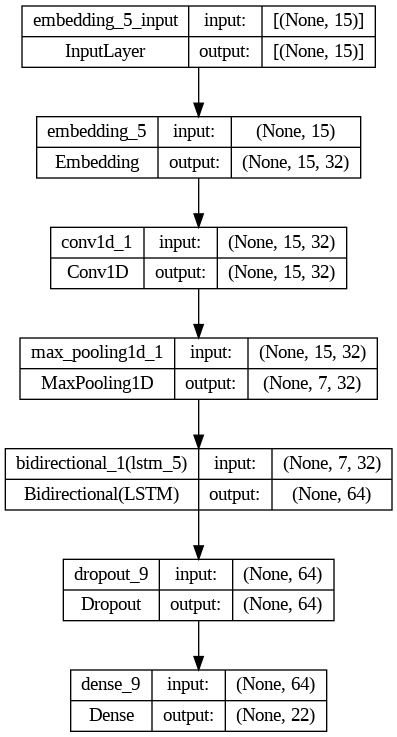

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [77]:
model.compile(loss='categorical_crossentropy', optimizer=adam, 
               metrics=['accuracy', Precision(), Recall()])

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
47/47 [==============================] - 6s 29ms/step - loss: 2.1816 - accuracy: 0.6936 - precision_5: 0.7558 - recall_5: 0.2311 - val_loss: 1.2411 - val_accuracy: 0.7480 - val_precision_5: 0.7480 - val_recall_5: 0.7480
Epoch 2/20
47/47 [==============================] - 0s 9ms/step - loss: 1.1930 - accuracy: 0.7331 - precision_5: 0.7378 - recall_5: 0.7019 - val_loss: 1.0416 - val_accuracy: 0.7480 - val_precision_5: 0.7487 - val_recall_5: 0.7480
Epoch 3/20
47/47 [==============================] - 0s 9ms/step - loss: 1.0191 - accuracy: 0.7334 - precision_5: 0.7883 - recall_5: 0.7234 - val_loss: 0.8498 - val_accuracy: 0.7480 - val_precision_5: 0.8904 - val_recall_5: 0.7420
Epoch 4/20
47/47 [==============================] - 0s 9ms/step - loss: 0.8171 - accuracy: 0.7589 - precision_5: 0.9260 - recall_5: 0.7204 - val_loss: 0.7149 - val_accuracy: 0.8022 - val_precision_5: 0.9574 - val_recall_5: 0.7219
Epoch 5/20
47/47 [==============================] - 1s 11ms/step - loss: 0.6584

In [78]:
preds = model.predict(X_val).argmax(axis=1)
print(f'f1_score = {f1_score(y_val.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_val.idxmax(axis=1), preds)}')
scores["validation"]["BiLSTM"] = {}
scores["validation"]["BiLSTM"]["f1_score"] = f1_score(y_val.idxmax(axis=1), preds, average="micro")
scores["validation"]["BiLSTM"]["accuracy_score"] = accuracy_score(y_val.idxmax(axis=1), preds)
print_result(preds, y_val.idxmax(axis=1))

32/32 [==============================] - 1s 4ms/step
f1_score = 0.9307228915662651
accuracy_score = 0.9307228915662651


,precision,recall,f1-score,support
atis_abbreviation,0.84,0.66,0.74,32.00
atis_aircraft,0.84,0.84,0.84,19.00
atis_airfare,0.97,0.93,0.95,81.00
atis_airline,0.64,0.82,0.72,33.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,1.00
atis_capacity,0.33,0.50,0.40,2.00
atis_city,1.00,0.33,0.50,3.00
atis_distance,0.00,0.00,0.00,1.00
atis_flight,0.98,0.98,0.98,746.00


In [79]:
preds = model.predict(X_test).argmax(axis=1)
print(f'f1_score = {f1_score(y_test.idxmax(axis=1), preds, average="micro")}')
print(f'accuracy_score = {accuracy_score(y_test.idxmax(axis=1), preds)}')
scores["test"]["BiLSTM"] = {}
scores["test"]["BiLSTM"]["f1_score"] = f1_score(y_test.idxmax(axis=1), preds, average="micro")
scores["test"]["BiLSTM"]["accuracy_score"] = accuracy_score(y_test.idxmax(axis=1), preds)
print_result(preds, y_test.idxmax(axis=1))

32/32 [==============================] - 0s 4ms/step
f1_score = 0.9397590361445783
accuracy_score = 0.9397590361445783


,precision,recall,f1-score,support
atis_abbreviation,1.00,0.73,0.84,44.00
atis_aircraft,0.67,0.73,0.70,11.00
atis_airfare,0.96,0.92,0.94,88.00
atis_airline,0.85,0.77,0.81,44.00
atis_airline#atis_flight_no,0.00,0.00,0.00,0.00
atis_airport,0.00,0.00,0.00,0.00
atis_capacity,0.20,1.00,0.33,1.00
atis_city,0.20,0.50,0.29,2.00
atis_distance,0.25,1.00,0.40,1.00
atis_flight,0.98,0.98,0.98,726.00


<a name="step4"> </a>
# Comparisons

[To the ToC](#content)

In [83]:
df = pd.DataFrame.from_dict({(i,j): scores[i][j] for i in scores.keys() for j in scores[i].keys()}, orient='index')

new_cols = pd.MultiIndex.from_product([df.columns.unique(level=0), ['f1_score', 'accuracy_score']])


df.index.names = ['Dataset', 'Model']
df.round(2)

f1_score  accuracy_score
Dataset    Model                                       
validation LogisticRegression      0.66            0.93
           SVM                     0.74            0.94
           Random Forest           0.50            0.89
           KNN                     0.47            0.88
           LSTM                    0.94            0.94
           GRU                     0.93            0.93
           BiLSTM                  0.93            0.93
test       LogisticRegression      0.54            0.93
           SVM                     0.51            0.94
           Random Forest           0.39            0.89
           KNN                     0.48            0.90
           SpaCy                   0.47            0.85
           LSTM                    0.95            0.95
           GRU                     0.94            0.94
           BiLSTM                  0.94            0.94

Since the classes are very poorly balanced, some classifiers show poor quality. To improve results, it is necessary to perform stratification or balancing